In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission
from evaluation import Referee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern

os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'

# General settings for figures
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Baseline for M5Forecast - Accuracy
This notebook calculates the mean of the final $k$ training days and multiplies those with the typical weekly pattern to create a slightly more advanced baseline. 

In [3]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# select true sales period
sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

In [4]:
# create referee with true sales
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Determine weekly pattern

In [5]:
sales_train

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1881,d_1882,d_1883,d_1884,d_1885,item_id,dept_id,cat_id,store_id,state_id
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,0,1,1,1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,3,5,0,6,6,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,0,...,0,0,0,0,0,FOODS_3_823,FOODS_3,FOODS,WI_3,WI
FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,FOODS_3_824,FOODS_3,FOODS,WI_3,WI
FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,2,...,0,0,2,0,1,FOODS_3_825,FOODS_3,FOODS,WI_3,WI


In [6]:
col_list = []
col_names = []

for i in range(1, 1+7):
    # select days from a certain day of the week
    cols = list(calendar[calendar.wday == i].d.values)
    col_name = calendar[calendar.wday == i].weekday.values[0]
    # filter days to match training set
    cols = [d for d in cols if d in sales_train.columns]
    col_list.append(cols); col_names.append(col_name)
    print("{} is day nr. {} of the week".format(col_name, i))

Saturday is day nr. 1 of the week
Sunday is day nr. 2 of the week
Monday is day nr. 3 of the week
Tuesday is day nr. 4 of the week
Wednesday is day nr. 5 of the week
Thursday is day nr. 6 of the week
Friday is day nr. 7 of the week


In [7]:
num_sales = [sales_train[cols].sum(axis=1).sum() for cols in col_list]

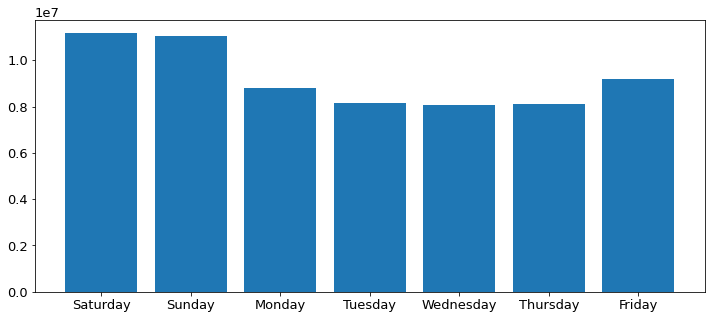

In [8]:
x = range(len(col_names))
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x, height=num_sales)
ax.set_xticks(x)
ax.set_xticklabels(col_names)
plt.show()

In [9]:
portions = np.array(num_sales) / np.sum(num_sales)
portions

array([0.17326312, 0.17140915, 0.13659388, 0.12618622, 0.12479437,
       0.12556788, 0.14218537])

## Predict weekly sales as mean of final $k$ days times weekly pattern
Based on the results shown in `k-day-average.ipynb` and semantic preference for multiples of 7, $k$ is set to 28. 

In [10]:
k = 28

# create skeleton for predictions
sales_pred = sales_true.copy()
day_cols = sales_pred.filter(regex='d_').columns
sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

# set all predictions to training mean of last k days
df = select_dates(sales_train, num_days=k, day_end=select_final_day(sales_train))
weekly_mean = df.filter(regex='d_').mean(axis=1) * 7
for dday in day_cols:
    week_day = calendar[calendar.d == dday].wday.values[0]
    portion = portions[week_day-1]
    sales_pred[dday] = weekly_mean * portion

# evaluate predictions
metrics = ref.evaluate(sales_pred)
print(metrics)

{1: 0.4491440579287355, 2: 0.5395858627134175, 3: 0.6393245847663551, 4: 0.520157107345135, 5: 0.6215425434172679, 6: 0.6128971368563063, 7: 0.6931805862629787, 8: 0.7047459037888377, 9: 0.7624465639633579, 10: 0.8624639178462569, 11: 0.8638069394341243, 12: 0.8513068162866345, 'WRMSSE': 0.676716835050784}


**Result**: Incorporating the weekly pattern reduces the WRMSSE signigicantly, from ~1.1 to ~0.67. 

## Create submission

In [11]:
create_submission(sales_pred, filename='weekly_pattern_fold1', add_timestamp=False)

Submit the predictions using:

`kaggle competitions submit -c m5-forecasting-accuracy -f submissions/submission_weekly_pattern.csv -m "Mean final 30 train days times weekly pattern"`

## Create forecast with KDayMeanTimesWeeklyPattern agent
Selection of training and validation set is handled by the CrossValiDataGenerator. The value for $k$ is changed to 28 for semantic reasons. 

In [12]:
k = 28
# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
train_df, val_df = cv_generator.get_train_val_split(fold=1, train_size=-1)

In [13]:
# Define model, with mean of k days
model = KDayMeanTimesWeeklyPattern(calendar, k=k)

# Determine the weekly pattern based on complete training set
model.fit(train_df)

# Predict next 28 days based on the k days before it and the weekly pattern
sales_pred = model.predict(train_df)
sales_pred

,item_id,dept_id,cat_id,store_id,state_id,d_1886,d_1887,d_1888,d_1889,d_1890,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.956157,0.883304,0.873561,0.878975,0.995298,...,0.995298,1.212842,1.199864,0.956157,0.883304,0.873561,0.878975,0.995298,1.212842,1.199864
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.307336,0.283919,0.280787,0.282528,0.319917,...,0.319917,0.389842,0.385671,0.307336,0.283919,0.280787,0.282528,0.319917,0.389842,0.385671
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0.512227,0.473198,0.467979,0.470880,0.533195,...,0.533195,0.649737,0.642784,0.512227,0.473198,0.467979,0.470880,0.533195,0.649737,0.642784
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1.809869,1.671967,1.653525,1.663774,1.883956,...,1.883956,2.295736,2.271171,1.809869,1.671967,1.653525,1.663774,1.883956,2.295736,2.271171
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1.058603,0.977943,0.967156,0.973151,1.101937,...,1.101937,1.342789,1.328421,1.058603,0.977943,0.967156,0.973151,1.101937,1.342789,1.328421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0.239039,0.220826,0.218390,0.219744,0.248824,...,0.248824,0.303210,0.299966,0.239039,0.220826,0.218390,0.219744,0.248824,0.303210,0.299966
FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1.195196,1.104129,1.091951,1.098719,1.244122,...,1.244122,1.516052,1.499830,1.195196,1.104129,1.091951,1.098719,1.244122,1.516052,1.499830


In [14]:
ref = Referee(val_df, train_df, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [15]:
ref.evaluate(sales_pred)

{1: 0.4491440579287355,
 2: 0.5395858627134175,
 3: 0.6393245847663551,
 4: 0.520157107345135,
 5: 0.6215425434172679,
 6: 0.6128971368563063,
 7: 0.6931805862629787,
 8: 0.7047459037888377,
 9: 0.7624465639633579,
 10: 0.8624639178462569,
 11: 0.8638069394341243,
 12: 0.8513068162866345,
 'WRMSSE': 0.676716835050784}

## Cross-validation of performance

In [16]:
k = 28
cv_generator = CrossValiDataGenerator(sales_train_validation, train_size=k)
train_df, _ = cv_generator.get_train_val_split(fold=10, train_size=-1)

### Determine weekly pattern with days before validation set nr. 10

In [17]:
model.fit(train_df)
model.portions

array([0.17337304, 0.17105435, 0.13658724, 0.12610984, 0.12460889,
       0.12514649, 0.14312014])

### Predict and evaluate

In [18]:
metrics_list = []

for fold in tqdm(range(1, 1+10), "CV"):
    # The train df should contain at least 28 days, for correct weights during evaluation
    train_df, val_df = cv_generator.get_train_val_split(fold=fold, train_size=max(28, k))
    
    # Predict next 28 days based on the k days before it 
    sales_pred = model.predict(train_df)
    
    # evaluate predictions
    ref = Referee(val_df, train_df, sell_prices, calendar, verbose=False)
    metrics = ref.evaluate(sales_pred)
    # print(metrics)
    metrics_list.append(metrics)

CV: 100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


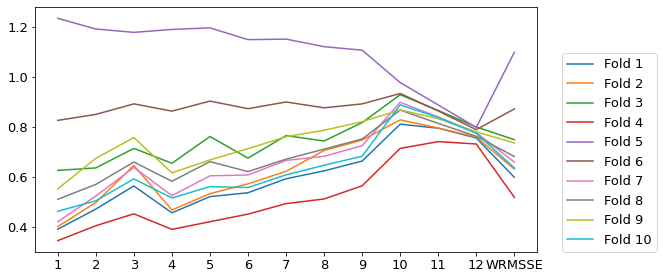

In [19]:
def plot_dict(dictionaries, exclude_zero=False, labels=[]):
    f, ax = plt.subplots(1, 1)
    
    if isinstance(dictionaries, dict):
        dictionaries = [dictionaries]
        labels = [labels]
    
    for i, dic in enumerate(dictionaries):
        keys = list(dic.keys())
        vals = list(dic.values())
        if exclude_zero:
            keys = [k for k in keys if k != 0]
            vals = [val for (k, val) in dic.items() if k != 0]
        
        try:
            ax.plot(keys, vals, label=labels[i])
        except:
            ax.plot(keys, vals)
    
    if len(labels) > 0:
        plt.legend(loc=(1.05, 0.))

    plt.show()

plot_dict(metrics_list, labels=['Fold %d'%d for d in range(1, 1+10)])